In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 5585, done.
remote: Counting objects: 100% (774/774), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 5585 (delta 663), reused 648 (delta 555), pack-reused 4811
Receiving objects: 100% (5585/5585), 2.87 GiB | 45.21 MiB/s, done.
Resolving deltas: 100% (4489/4489), done.
Updating files: 100% (485/485), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 22.3 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 40.8 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tuned-models/slim_recall_xgboost_train

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 50,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [24]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 2092.42 column/sec. Elapsed time 10.68 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1357.80 column/sec. Elapsed time 9.59 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 4788.38 column/sec. Elapsed time 4.67 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [25]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [26]:
print('Merging Models')
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
print('MultVAE')
result_df, _ = evaluator.evaluateRecommender(recommender_vae)
display(result_df)
# print('ALS')
# result_df, _ = evaluator.evaluateRecommender(recommender_als)
# display(result_df)

Merging Models
EvaluatorHoldout: Processed 10456 (100.0%) in 5.64 sec. Users per second: 1853


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081207,0.139076,0.117361,0.039491,0.06875,0.237151,0.127435,0.095993,0.47523,0.303409,...,0.802826,0.381526,0.802826,0.090972,10.726299,0.998441,0.266038,0.82708,1.500923,0.387352


Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 5.32 sec. Users per second: 1966


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079141,0.134235,0.112828,0.038628,0.066894,0.232462,0.124094,0.093029,0.464327,0.297299,...,0.802826,0.372773,0.802826,0.075712,10.418373,0.997966,0.221413,0.803337,1.652023,0.383676


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 5.49 sec. Users per second: 1903


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079658,0.136429,0.115204,0.038171,0.066535,0.231172,0.124353,0.094189,0.47303,0.294753,...,0.802826,0.37976,0.802826,0.096602,10.808804,0.998526,0.282504,0.833442,1.437561,0.390783


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 5.25 sec. Users per second: 1991


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076664,0.128535,0.10787,0.037284,0.064338,0.227507,0.119981,0.089628,0.456676,0.289145,...,0.802826,0.366631,0.802826,0.072251,10.504764,0.998262,0.21129,0.809998,1.371811,0.386528


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 8.69 sec. Users per second: 1203


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061477,0.112346,0.096871,0.028592,0.05208,0.191056,0.099645,0.075218,0.406848,0.232673,...,0.802826,0.326628,0.802826,0.011358,7.735149,0.986167,0.033216,0.59644,3.662361,0.323459


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 7.82 sec. Users per second: 1338


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051415,0.084267,0.069573,0.024792,0.040821,0.165486,0.079928,0.059132,0.338849,0.201455,...,0.802826,0.272036,0.802826,0.018774,9.145243,0.997874,0.054903,0.705169,1.326454,0.362589


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 7.45 sec. Users per second: 1404


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 8.84 sec. Users per second: 1182


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.090327,0.076977,0.025086,0.043651,0.170985,0.084357,0.062638,0.35635,0.206245,...,0.802826,0.286087,0.802826,0.013232,8.625793,0.996729,0.038694,0.665115,1.992554,0.343623


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 10.06 sec. Users per second: 1040


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.053395,0.088783,0.074181,0.025534,0.042764,0.173646,0.083816,0.062095,0.355777,0.20946,...,0.802826,0.285627,0.802826,0.018466,9.043891,0.997531,0.054003,0.697354,1.425533,0.361464


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 6.45 sec. Users per second: 1622


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.057154,0.100577,0.085625,0.026561,0.047843,0.179969,0.091756,0.068551,0.382269,0.217765,...,0.802826,0.306895,0.802826,0.030224,8.973277,0.994651,0.088387,0.691909,2.634383,0.346626


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 9.08 sec. Users per second: 1152


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079839,0.135985,0.114694,0.038588,0.0664,0.233862,0.124583,0.094144,0.472743,0.298541,...,0.802826,0.37953,0.802826,0.053029,10.313128,0.998528,0.155077,0.795222,1.619657,0.371056


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 8.73 sec. Users per second: 1198


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.07523,0.130395,0.110728,0.036193,0.063731,0.2264,0.119463,0.089591,0.46031,0.284432,...,0.802826,0.369549,0.802826,0.030039,9.477048,0.99708,0.087846,0.730753,2.146813,0.353406


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 10.05 sec. Users per second: 1041


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.069539,0.122979,0.105423,0.032759,0.05783,0.209923,0.11029,0.083801,0.437835,0.260966,...,0.802826,0.351505,0.802826,0.024802,9.523511,0.998258,0.072532,0.734336,1.744761,0.356885


MultVAE
EvaluatorHoldout: Processed 10456 (100.0%) in 12.62 sec. Users per second: 829


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.066115,0.123357,0.107416,0.029619,0.054903,0.197963,0.106087,0.081851,0.435731,0.241465,...,0.802826,0.349816,0.802826,0.016447,7.902069,0.982289,0.048098,0.60931,3.855345,0.321449


In [27]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/3291901882.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[35, 100, 505, 428, 591, 693, 402, 1480, 122, 617, 976, 868, 3, 514, 111, 2, 636, 1545, 256, 341, 336, 1629, 101, 9, 84, 1, 0, 1421, 849, 1287, 1934, 1082, 1213, 53, 28, 288, 1056, 57, 76, 75, 921, 86, 1337, 2498, 772, 136, 283, 533, 97, 155]


,ItemID
UserID,
0,35
0,100
0,505
0,428
0,591
...,...
13023,170
13023,605
13023,6214


In [28]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [29]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,428,False
4,0,591,False
...,...,...,...
651195,13023,170,False
651196,13023,605,True
651197,13023,6214,False
651198,13023,1373,False


In [30]:
training_dataframe.Label.sum()

15808

In [31]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [32]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [34]:
tmp.ItemID.values.astype(int)

array([  35,  100,  505,  428,  591,  693,  402, 1480,  122,  617,  976,
        868,    3,  514,  111,    2,  636, 1545,  256,  341,  336, 1629,
        101,    9,   84,    1,    0, 1421,  849, 1287, 1934, 1082, 1213,
         53,   28,  288, 1056,   57,   76,   75,  921,   86, 1337, 2498,
        772,  136,  283,  533,   97,  155])

In [35]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([    0,     1,     2,    12,     3,     4,     6,     5,     9,
           7,    48,  8148,  7493,    26,    50,  7492,    39,    11,
        7687,     8,  7637,    29,    27,  7498,  7527,  7491, 21981,
          10,    43,    14,    41,    13,    16,  7540,  7473,  7589,
          23,  7544,  7519,    34,    60,  7529,    15,  6456,    33,
        7423,  7584,  7087,  7410,    45])

In [36]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [37]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

# todo: weighted score makes sense? Same features of position but for score might be not useful
# since ranges are different

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/2167912425.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_19/2167912425.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,0.092288,0.0,0.017127,5.003698,23.036989,12,1.769231,4.361839,3.374200,11.722106
1,0,100,False,0.550739,1.0,1.0,0.205031,1.0,1.0,0.551174,...,0.086162,0.0,0.018270,3.696277,12.423644,13,0.538462,0.518875,-0.175204,-2.363636
2,0,505,False,0.524022,2.0,1.0,0.122233,2.0,1.0,0.354394,...,0.073953,0.0,0.018064,2.531372,5.318754,13,2.769231,1.300887,1.843942,2.645417
3,0,428,False,0.242514,12.0,0.0,0.117215,3.0,1.0,0.167343,...,0.067306,0.0,0.019153,1.729575,1.577202,6,17.076923,17.872052,1.403825,1.169377
4,0,591,False,0.513606,3.0,1.0,0.041148,68.0,0.0,0.260866,...,0.082681,0.0,0.015344,5.003704,23.037041,6,70.076923,131.389663,2.596045,6.857221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,0.041414,0.0,0.006039,6.559126,41.022152,2,60.000000,42.634102,0.441703,-0.670449
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.059903,0.0,0.008736,6.559142,41.022297,3,52.230769,41.342379,0.440308,-0.859601
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,0.036249,0.0,0.009074,2.990309,7.077977,1,263.538462,452.875004,2.874296,9.014118
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,0.039994,0.0,0.005832,6.559140,41.022385,0,1278.692308,2982.912178,2.178514,3.224866


In [38]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,23.036989,12,1.769231,4.361839,3.374200,11.722106,0.411713,0.033573,77.384713,77.185358
1,0,100,False,0.550739,1.0,1.0,0.205031,1.0,1.0,0.551174,...,12.423644,13,0.538462,0.518875,-0.175204,-2.363636,0.232476,0.033573,77.384713,90.053545
2,0,505,False,0.524022,2.0,1.0,0.122233,2.0,1.0,0.354394,...,5.318754,13,2.769231,1.300887,1.843942,2.645417,0.079858,0.033573,77.384713,102.144698
3,0,428,False,0.242514,12.0,0.0,0.117215,3.0,1.0,0.167343,...,1.577202,6,17.076923,17.872052,1.403825,1.169377,0.044366,0.033573,77.384713,97.835492
4,0,591,False,0.513606,3.0,1.0,0.041148,68.0,0.0,0.260866,...,23.037041,6,70.076923,131.389663,2.596045,6.857221,0.086069,0.033573,77.384713,86.651586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,170,False,0.068760,73.0,0.0,0.381633,5.0,1.0,0.081454,...,41.022152,2,60.000000,42.634102,0.441703,-0.670449,0.173026,0.055156,53.265190,98.486897
651196,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,41.022297,3,52.230769,41.342379,0.440308,-0.859601,0.079858,0.055156,53.265190,94.862590
651197,13023,6214,False,0.114844,39.0,0.0,0.153297,100.0,0.0,0.252423,...,7.077977,1,263.538462,452.875004,2.874296,9.014118,0.011535,0.055156,53.265190,169.226711
651198,13023,1373,False,0.056598,102.0,0.0,0.234818,36.0,0.0,0.000000,...,41.022385,0,1278.692308,2982.912178,2.178514,3.224866,0.047915,0.055156,53.265190,112.935230


In [39]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.771709,0.0,1.0,0.215686,0.0,1.0,0.804430,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,1421,False,0.273926,10.0,0.0,0.016866,438.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,849,False,0.109069,43.0,0.0,0.047095,46.0,0.0,0.063939,...,0.007942,-0.005888,0.008819,-0.006112,0.006760,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,1287,False,0.228756,14.0,0.0,0.019282,351.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1934,True,0.111270,41.0,0.0,0.031756,125.0,0.0,0.061394,...,0.005471,0.001350,0.008471,-0.005479,0.002262,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651193,13023,389,False,0.054072,106.0,0.0,0.059093,621.0,0.0,0.086976,...,0.011188,-0.017740,-0.005322,-0.011841,-0.004538,0.006896,-0.007143,0.001571,0.006195,0.023549
651176,13023,2195,False,0.096075,48.0,0.0,0.219686,48.0,0.0,0.049547,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
651189,13023,180,False,0.093238,53.0,0.0,0.026436,2196.0,0.0,0.096624,...,0.028602,-0.007037,-0.013733,0.010851,-0.019142,0.006896,-0.007143,0.001571,0.006195,0.023549
651170,13023,349,False,0.129561,30.0,0.0,0.353050,8.0,1.0,0.167004,...,0.023461,-0.039074,0.033606,0.036253,0.073695,0.006896,-0.007143,0.001571,0.006195,0.023549


In [40]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [41]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [42]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=500,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

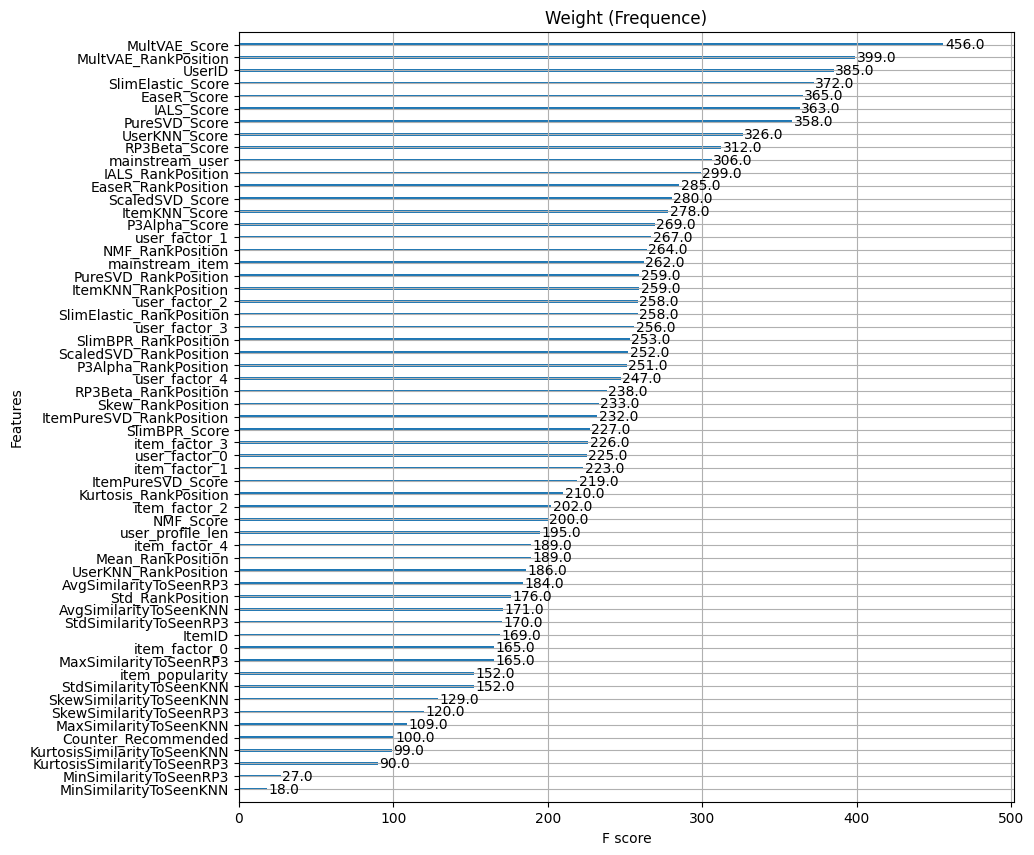

In [43]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

In [44]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1791.62 column/sec. Elapsed time 12.47 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1250.94 column/sec. Elapsed time 10.41 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 4080.01 column/sec. Elapsed time 5.48 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity col

In [45]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [46]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,35,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,0.0,...,0.018748,5.003693,23.036957,11,1.923077,4.071477,2.175531,3.437792,0.406406,0.032075
1,0,100,0.830547,1.0,1.0,0.296112,1.0,1.0,0.744487,1.0,...,0.018819,3.772862,13.105057,13,0.692308,0.480384,-0.946212,-1.339394,0.237011,0.032075
2,0,505,0.471617,3.0,1.0,0.135064,4.0,1.0,0.288312,3.0,...,0.016424,2.626812,5.960841,13,4.307692,2.287087,1.133427,0.077800,0.074733,0.032075
3,0,51,0.213902,19.0,0.0,0.042878,115.0,0.0,0.111361,14.0,...,0.000000,NaN,NaN,6,30.769231,55.858682,2.403743,5.283801,0.202135,0.032075
4,0,402,0.598366,2.0,1.0,0.122285,5.0,1.0,0.283639,4.0,...,0.013440,3.071784,8.519635,10,6.692308,7.706973,2.386814,5.984663,0.074021,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651195,13023,242,0.094612,59.0,0.0,0.059399,687.0,0.0,0.057316,77.0,...,0.000000,NaN,NaN,2,117.307692,192.883983,2.601152,6.877059,0.113879,0.056604
651196,13023,852,0.056650,89.0,0.0,0.338165,19.0,0.0,0.000000,8068.0,...,0.000000,NaN,NaN,0,1288.307692,3018.009758,2.178100,3.221650,0.054093,0.056604
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.005985,6.559123,41.022182,0,752.846154,2283.326625,3.561836,12.762029,0.054804,0.056604
651198,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,219.384615,401.905158,2.519290,6.031258,0.004982,0.056604


In [47]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,0.0,...,0.070908,0.005731,0.083522,-0.090610,0.014975,0.005684,-0.001896,0.008995,-0.013853,-0.002147
27,0,86,0.000000,7530.0,0.0,0.078053,25.0,0.0,0.000000,7509.0,...,0.052802,0.039735,0.028306,-0.087907,-0.017382,0.005684,-0.001896,0.008995,-0.013853,-0.002147
28,0,1082,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
29,0,636,0.099262,55.0,0.0,0.070862,35.0,0.0,0.094083,21.0,...,0.009434,0.000249,0.008939,-0.006449,0.002131,0.005684,-0.001896,0.008995,-0.013853,-0.002147
30,0,1337,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,8325.0,...,0.012389,-0.028209,0.014298,-0.001750,0.041015,0.006896,-0.007143,0.001571,0.006195,0.023549
651194,13023,14,0.000000,7518.0,0.0,0.137722,155.0,0.0,0.000000,7480.0,...,0.095542,0.015748,0.113690,-0.135039,0.018867,0.006896,-0.007143,0.001571,0.006195,0.023549
651153,13023,732,0.467619,6.0,1.0,0.567250,0.0,1.0,0.406934,8.0,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
651154,13023,324,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,16.0,...,0.023976,-0.045454,0.032942,0.022102,0.076070,0.006896,-0.007143,0.001571,0.006195,0.023549


In [48]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [49]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [50]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 2.29 min. Users per second: 76


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.096959,0.169116,0.143146,0.047656,0.080855,0.263114,0.149225,0.11561,0.531178,0.349742,...,0.802826,0.426443,0.802826,0.04393,9.836073,0.99659,0.126756,0.757733,2.158948,0.289137


In [51]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [52]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [53]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning_fixed_added_vae_and_similarity_feature', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-23 12:17:03,115] Using an existing study with name 'xgboost_tuning_fixed_added_vae_and_similarity_feature' instead of creating a new one.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.62 min. Users per second: 67


[I 2023-12-23 12:22:27,193] Trial 50 finished with value: 0.05154223366852539 and parameters: {'objective': 'rank:map', 'n_estimators': 1165, 'learning_rate': 0.0008041093836862396, 'reg_alpha': 0.0001711384007110178, 'reg_lambda': 8.288929643313027e-05, 'max_depth': 5, 'max_leaves': 433, 'grow_policy': 'lossguide', 'gamma': 1.319899627239114, 'min_child_weight': 0.12871384672275557, 'subsample': 0.17725439218976202, 'colsample_bytree': 0.6857251826832588}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.75 min. Users per second: 63


[I 2023-12-23 12:32:07,197] Trial 51 finished with value: 0.05203509263307501 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3847, 'learning_rate': 0.004415852684203687, 'reg_alpha': 4.013872411588196e-05, 'reg_lambda': 4.50244032126638e-05, 'max_depth': 4, 'max_leaves': 38, 'grow_policy': 'depthwise', 'gamma': 5.500639102455682, 'min_child_weight': 0.46417490064915845, 'subsample': 0.27258451476531137, 'colsample_bytree': 0.864944165296301}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.72 min. Users per second: 64


[I 2023-12-23 12:40:13,328] Trial 52 finished with value: 0.05184921925286376 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2352, 'learning_rate': 0.0013789384991445485, 'reg_alpha': 1.4291387690375245e-05, 'reg_lambda': 0.00019680263285474362, 'max_depth': 9, 'max_leaves': 204, 'grow_policy': 'depthwise', 'gamma': 9.72848865435589, 'min_child_weight': 0.4104724107968782, 'subsample': 0.23302138507729733, 'colsample_bytree': 0.7906476786119145}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.03 min. Users per second: 57


[I 2023-12-23 12:51:21,140] Trial 53 finished with value: 0.05197408490302569 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4242, 'learning_rate': 0.002158319773219728, 'reg_alpha': 1.5948041833933914e-05, 'reg_lambda': 0.00011903483079214618, 'max_depth': 4, 'max_leaves': 114, 'grow_policy': 'depthwise', 'gamma': 1.8609166577862737, 'min_child_weight': 0.9184760908007268, 'subsample': 0.20885133567653524, 'colsample_bytree': 0.842474521718273}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.35 min. Users per second: 74


[I 2023-12-23 12:57:38,431] Trial 54 finished with value: 0.051940702383989235 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1877, 'learning_rate': 0.0027565967546024995, 'reg_alpha': 2.9723196381225334e-05, 'reg_lambda': 4.067915454254024e-05, 'max_depth': 6, 'max_leaves': 10, 'grow_policy': 'depthwise', 'gamma': 4.307688542481794, 'min_child_weight': 0.2171574948245039, 'subsample': 0.2875033685253916, 'colsample_bytree': 0.8959782169694139}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.55 min. Users per second: 68


[I 2023-12-23 13:06:46,682] Trial 55 finished with value: 0.05187641940224227 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3922, 'learning_rate': 0.005417334698305599, 'reg_alpha': 2.432254864876034e-05, 'reg_lambda': 1.7009619889314426e-05, 'max_depth': 3, 'max_leaves': 55, 'grow_policy': 'depthwise', 'gamma': 0.35048106584674904, 'min_child_weight': 0.4321647347996839, 'subsample': 0.38440076816375635, 'colsample_bytree': 0.7528990906110247}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.34 min. Users per second: 74


[I 2023-12-23 13:13:29,205] Trial 56 finished with value: 0.05206774267983186 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2547, 'learning_rate': 0.0036937402474054026, 'reg_alpha': 9.743753172975141e-05, 'reg_lambda': 8.088976938519297e-05, 'max_depth': 3, 'max_leaves': 145, 'grow_policy': 'depthwise', 'gamma': 1.2629186454179469, 'min_child_weight': 0.1450988230042701, 'subsample': 0.1464992285018235, 'colsample_bytree': 0.8356315912507125}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.37 min. Users per second: 73


[I 2023-12-23 13:20:09,557] Trial 57 finished with value: 0.05184824009302851 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2639, 'learning_rate': 0.0076246084828647375, 'reg_alpha': 0.00010822069892716567, 'reg_lambda': 0.00047739932514943726, 'max_depth': 3, 'max_leaves': 666, 'grow_policy': 'depthwise', 'gamma': 0.8099529991049316, 'min_child_weight': 0.09386067949227823, 'subsample': 0.18214271734741713, 'colsample_bytree': 0.7959859942791492}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.58 min. Users per second: 68


[I 2023-12-23 13:26:33,353] Trial 58 finished with value: 0.05142041176327751 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1764, 'learning_rate': 0.003543998040524721, 'reg_alpha': 0.0002479577352238244, 'reg_lambda': 8.11123917521675e-05, 'max_depth': 5, 'max_leaves': 271, 'grow_policy': 'depthwise', 'gamma': 0.07676840594563357, 'min_child_weight': 0.1718571231311269, 'subsample': 0.1339862355053628, 'colsample_bytree': 0.8325734976525618}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.63 min. Users per second: 66


[I 2023-12-23 13:34:47,169] Trial 59 finished with value: 0.05192481191022754 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 2978, 'learning_rate': 0.0017990647655497195, 'reg_alpha': 0.00014487834093512942, 'reg_lambda': 0.0001977370267326258, 'max_depth': 4, 'max_leaves': 146, 'grow_policy': 'depthwise', 'gamma': 1.548524939342006, 'min_child_weight': 0.042011305273667365, 'subsample': 0.15652181515899385, 'colsample_bytree': 0.7238082063803926}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.14 min. Users per second: 55


[I 2023-12-23 13:42:46,057] Trial 60 finished with value: 0.05161234986215906 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1592, 'learning_rate': 0.0009410743363323104, 'reg_alpha': 0.0003277967336481266, 'reg_lambda': 3.944603651901714e-05, 'max_depth': 7, 'max_leaves': 211, 'grow_policy': 'depthwise', 'gamma': 0.14539214696765154, 'min_child_weight': 0.013328414676551398, 'subsample': 0.24150960555871573, 'colsample_bytree': 0.8705997574763473}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.54 min. Users per second: 69


[I 2023-12-23 13:52:46,211] Trial 61 finished with value: 0.051970938687896 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4886, 'learning_rate': 0.005258739089905188, 'reg_alpha': 4.554639660048423e-05, 'reg_lambda': 1.0014321374310879e-05, 'max_depth': 3, 'max_leaves': 104, 'grow_policy': 'depthwise', 'gamma': 6.3326641670246975, 'min_child_weight': 0.5618337757936079, 'subsample': 0.189436645163839, 'colsample_bytree': 0.8761878745561541}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.88 min. Users per second: 60


[I 2023-12-23 14:03:12,699] Trial 62 finished with value: 0.05206616387947733 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3905, 'learning_rate': 0.002275120219049569, 'reg_alpha': 1.0388725688702021e-05, 'reg_lambda': 6.196393203605936e-05, 'max_depth': 4, 'max_leaves': 48, 'grow_policy': 'depthwise', 'gamma': 2.796215120470053, 'min_child_weight': 0.9807793414200539, 'subsample': 0.2633074344345661, 'colsample_bytree': 0.833777116264896}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.11 min. Users per second: 56


[I 2023-12-23 14:12:28,266] Trial 63 finished with value: 0.05166845420264558 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2334, 'learning_rate': 0.002199718803293281, 'reg_alpha': 8.35522262277708e-05, 'reg_lambda': 1.618719622073171e-05, 'max_depth': 6, 'max_leaves': 140, 'grow_policy': 'depthwise', 'gamma': 0.7017353122464758, 'min_child_weight': 0.1987958530118458, 'subsample': 0.3325040534586787, 'colsample_bytree': 0.8297676692312}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.79 min. Users per second: 62


[I 2023-12-23 14:22:45,859] Trial 64 finished with value: 0.052046838755905905 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3714, 'learning_rate': 0.0011995489632859106, 'reg_alpha': 4.7452014247614684e-05, 'reg_lambda': 6.113545031241067e-05, 'max_depth': 4, 'max_leaves': 60, 'grow_policy': 'depthwise', 'gamma': 3.1866138248810794, 'min_child_weight': 0.9944820625386878, 'subsample': 0.26678190220933296, 'colsample_bytree': 0.7932355742357644}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.94 min. Users per second: 59


[I 2023-12-23 14:31:48,141] Trial 65 finished with value: 0.05147263362116113 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2934, 'learning_rate': 0.003793824296313765, 'reg_alpha': 1.3227829271806501e-05, 'reg_lambda': 2.7854183953538276e-05, 'max_depth': 5, 'max_leaves': 47, 'grow_policy': 'depthwise', 'gamma': 2.1018147339380473, 'min_child_weight': 0.06681339018881473, 'subsample': 0.20209275029822635, 'colsample_bytree': 0.8422360027139856}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.60 min. Users per second: 48


[I 2023-12-23 14:44:35,685] Trial 66 finished with value: 0.05000463393084881 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4102, 'learning_rate': 0.0026183358848700386, 'reg_alpha': 2.6793169077420686e-05, 'reg_lambda': 0.00012018018764807963, 'max_depth': 6, 'max_leaves': 102, 'grow_policy': 'depthwise', 'gamma': 0.2898600902790337, 'min_child_weight': 0.4054848020467857, 'subsample': 0.13501322290364934, 'colsample_bytree': 0.7545841122639957}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.35 min. Users per second: 74


[I 2023-12-23 14:50:56,432] Trial 67 finished with value: 0.05211351270934332 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2384, 'learning_rate': 0.006481644638336637, 'reg_alpha': 0.00014455331213420537, 'reg_lambda': 8.238514342606232e-05, 'max_depth': 3, 'max_leaves': 184, 'grow_policy': 'depthwise', 'gamma': 1.046868551389372, 'min_child_weight': 0.15756734746787748, 'subsample': 0.24553992931457574, 'colsample_bytree': 0.7713125504949426}. Best is trial 40 with value: 0.05213409404185096.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.19 min. Users per second: 80


[I 2023-12-23 14:55:24,735] Trial 68 finished with value: 0.052172254709076306 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1260, 'learning_rate': 0.005099923259434489, 'reg_alpha': 0.0001515984558886142, 'reg_lambda': 8.706421420563148e-05, 'max_depth': 3, 'max_leaves': 317, 'grow_policy': 'lossguide', 'gamma': 0.46235169366776885, 'min_child_weight': 0.16278261783437406, 'subsample': 0.22484583039667932, 'colsample_bytree': 0.7786791968860105}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.17 min. Users per second: 80


[I 2023-12-23 14:59:37,953] Trial 69 finished with value: 0.051900040684471245 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1229, 'learning_rate': 0.008103518535714022, 'reg_alpha': 0.00021769886516281934, 'reg_lambda': 9.229186040269305e-05, 'max_depth': 3, 'max_leaves': 380, 'grow_policy': 'lossguide', 'gamma': 0.9568564041913167, 'min_child_weight': 0.055951817474354675, 'subsample': 0.31649194349359666, 'colsample_bytree': 0.7940447765391598}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.16 min. Users per second: 42


[I 2023-12-23 15:11:13,833] Trial 70 finished with value: 0.04498841707047565 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1612, 'learning_rate': 0.006332735647060771, 'reg_alpha': 9.063952247900753e-05, 'reg_lambda': 2.6016761899708742e-05, 'max_depth': 11, 'max_leaves': 322, 'grow_policy': 'lossguide', 'gamma': 0.3911485038514641, 'min_child_weight': 0.09563995607668939, 'subsample': 0.24181519829578466, 'colsample_bytree': 0.7063384348013507}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.33 min. Users per second: 75


[I 2023-12-23 15:17:48,047] Trial 71 finished with value: 0.0521407242443016 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2506, 'learning_rate': 0.004699053675939274, 'reg_alpha': 0.00015750855903689875, 'reg_lambda': 0.00016260014640101235, 'max_depth': 3, 'max_leaves': 244, 'grow_policy': 'lossguide', 'gamma': 0.5455373679882578, 'min_child_weight': 0.1643036795689155, 'subsample': 0.2202925353095613, 'colsample_bytree': 0.7674962685961314}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.36 min. Users per second: 74


[I 2023-12-23 15:24:15,479] Trial 72 finished with value: 0.051989561700732656 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2517, 'learning_rate': 0.004311934508068095, 'reg_alpha': 0.00044317702642516273, 'reg_lambda': 3.4311614096545185e-05, 'max_depth': 3, 'max_leaves': 250, 'grow_policy': 'lossguide', 'gamma': 5.658036563362317, 'min_child_weight': 0.16740843855697618, 'subsample': 0.10872985836958557, 'colsample_bytree': 0.76306026475944}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.31 min. Users per second: 76


[I 2023-12-23 15:30:02,172] Trial 73 finished with value: 0.0514467390182296 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2149, 'learning_rate': 0.010865005349621268, 'reg_alpha': 0.00013612278006589298, 'reg_lambda': 4.87402275261091e-05, 'max_depth': 3, 'max_leaves': 188, 'grow_policy': 'lossguide', 'gamma': 1.1854373232778201, 'min_child_weight': 0.25395481871347014, 'subsample': 0.15289938470913877, 'colsample_bytree': 0.7372392671795263}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.98 min. Users per second: 59


[I 2023-12-23 15:39:25,601] Trial 74 finished with value: 0.05100150213745309 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3109, 'learning_rate': 0.0049630039047881365, 'reg_alpha': 6.501218694990515e-05, 'reg_lambda': 1.5769881523648075e-05, 'max_depth': 5, 'max_leaves': 314, 'grow_policy': 'lossguide', 'gamma': 0.6958622136487158, 'min_child_weight': 0.03257429063536857, 'subsample': 0.28317244199541086, 'colsample_bytree': 0.813716981777731}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.21 min. Users per second: 79


[I 2023-12-23 15:44:13,683] Trial 75 finished with value: 0.05209371698181994 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1416, 'learning_rate': 0.0033180688414315785, 'reg_alpha': 0.00022980136385414833, 'reg_lambda': 0.00014501383308623928, 'max_depth': 3, 'max_leaves': 241, 'grow_policy': 'lossguide', 'gamma': 1.8418193640088831, 'min_child_weight': 0.08850404415360627, 'subsample': 0.22472864731504513, 'colsample_bytree': 0.7753049907626893}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.32 min. Users per second: 75


[I 2023-12-23 15:49:10,380] Trial 76 finished with value: 0.05182296410658165 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1367, 'learning_rate': 0.006456556911005441, 'reg_alpha': 0.0002540040604278978, 'reg_lambda': 0.0001443081381927533, 'max_depth': 4, 'max_leaves': 279, 'grow_policy': 'lossguide', 'gamma': 2.2187305654365104, 'min_child_weight': 0.07724198076747947, 'subsample': 0.22303554372080017, 'colsample_bytree': 0.7737237244850671}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.26 min. Users per second: 77


[I 2023-12-23 15:54:28,012] Trial 77 finished with value: 0.0518086600235611 and parameters: {'objective': 'rank:map', 'n_estimators': 1683, 'learning_rate': 0.0031420014808450267, 'reg_alpha': 0.0008154020950622435, 'reg_lambda': 0.0002717423716867403, 'max_depth': 3, 'max_leaves': 239, 'grow_policy': 'lossguide', 'gamma': 0.5077094668682989, 'min_child_weight': 0.3391336608996072, 'subsample': 0.3506419844587192, 'colsample_bytree': 0.7044269393885765}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.51 min. Users per second: 69


[I 2023-12-23 16:00:52,122] Trial 78 finished with value: 0.05148262256955877 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2113, 'learning_rate': 0.008709637151641077, 'reg_alpha': 0.00038629740588144924, 'reg_lambda': 1.435488539821713e-05, 'max_depth': 10, 'max_leaves': 501, 'grow_policy': 'lossguide', 'gamma': 7.102509538690285, 'min_child_weight': 0.06487529414113302, 'subsample': 0.31208374600062355, 'colsample_bytree': 0.7692377101617486}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.54 min. Users per second: 38


[I 2023-12-23 16:15:12,195] Trial 79 finished with value: 0.04639957994802151 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3261, 'learning_rate': 0.011263815999716272, 'reg_alpha': 0.00016386490014770833, 'reg_lambda': 0.00019064064551180094, 'max_depth': 19, 'max_leaves': 347, 'grow_policy': 'lossguide', 'gamma': 2.352573909383958, 'min_child_weight': 0.21021070940248024, 'subsample': 0.25195270017856186, 'colsample_bytree': 0.6475097575121209}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.24 min. Users per second: 78


[I 2023-12-23 16:19:12,895] Trial 80 finished with value: 0.0515200393789247 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 911, 'learning_rate': 0.01490469463474447, 'reg_alpha': 6.151576602502015e-05, 'reg_lambda': 2.292782063797188e-05, 'max_depth': 4, 'max_leaves': 420, 'grow_policy': 'lossguide', 'gamma': 0.23696541489090156, 'min_child_weight': 0.5497813001352103, 'subsample': 0.28651613532748577, 'colsample_bytree': 0.8107937778601341}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.39 min. Users per second: 73


[I 2023-12-23 16:26:04,762] Trial 81 finished with value: 0.052019012399655666 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2614, 'learning_rate': 0.003606743006551253, 'reg_alpha': 9.820022945712691e-05, 'reg_lambda': 7.644276866734388e-05, 'max_depth': 3, 'max_leaves': 218, 'grow_policy': 'lossguide', 'gamma': 1.3378984863592374, 'min_child_weight': 0.1288547876241556, 'subsample': 0.19499279451732368, 'colsample_bytree': 0.7873505481370904}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.51 min. Users per second: 69


[I 2023-12-23 16:35:31,594] Trial 82 finished with value: 0.05212719058549251 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4428, 'learning_rate': 0.005017427607581708, 'reg_alpha': 0.00027004438982847255, 'reg_lambda': 0.00010026442227231338, 'max_depth': 3, 'max_leaves': 174, 'grow_policy': 'lossguide', 'gamma': 5.668214488480895, 'min_child_weight': 0.10248720482292079, 'subsample': 0.2288721993592809, 'colsample_bytree': 0.8720299182545331}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.91 min. Users per second: 60


[I 2023-12-23 16:46:11,628] Trial 83 finished with value: 0.05101352151419146 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4356, 'learning_rate': 0.006120663066439887, 'reg_alpha': 0.0003104236159325246, 'reg_lambda': 3.851659250467382e-05, 'max_depth': 4, 'max_leaves': 176, 'grow_policy': 'lossguide', 'gamma': 3.9276569262120575, 'min_child_weight': 0.03049198630609189, 'subsample': 0.22709802318851335, 'colsample_bytree': 0.883898553143722}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.94 min. Users per second: 59


[I 2023-12-23 16:57:10,681] Trial 84 finished with value: 0.05092294543423118 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4921, 'learning_rate': 0.007494735138037341, 'reg_alpha': 0.00020059862117836265, 'reg_lambda': 0.00012908502022951476, 'max_depth': 5, 'max_leaves': 294, 'grow_policy': 'lossguide', 'gamma': 5.509804521199215, 'min_child_weight': 0.09384087130064277, 'subsample': 0.2524998939424884, 'colsample_bytree': 0.8511526526845963}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.34 min. Users per second: 74


[I 2023-12-23 17:04:45,671] Trial 85 finished with value: 0.05203562396011752 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3321, 'learning_rate': 0.004961067036274116, 'reg_alpha': 0.00012095455955078196, 'reg_lambda': 6.09053544656918e-05, 'max_depth': 3, 'max_leaves': 248, 'grow_policy': 'lossguide', 'gamma': 8.577094618022837, 'min_child_weight': 0.3330340771745809, 'subsample': 0.30564903944084915, 'colsample_bytree': 0.8139524529618266}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.31 min. Users per second: 53


[I 2023-12-23 17:17:06,542] Trial 86 finished with value: 0.051367070323411576 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4354, 'learning_rate': 0.0028230686041337025, 'reg_alpha': 3.542040089413291e-05, 'reg_lambda': 0.00010862153971129032, 'max_depth': 5, 'max_leaves': 183, 'grow_policy': 'lossguide', 'gamma': 1.8408219318908006, 'min_child_weight': 0.04915321404459327, 'subsample': 0.21684835423634014, 'colsample_bytree': 0.8796605023717472}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.45 min. Users per second: 71


[I 2023-12-23 17:23:17,127] Trial 87 finished with value: 0.05197305640567945 and parameters: {'objective': 'rank:map', 'n_estimators': 2066, 'learning_rate': 0.0043637326112600915, 'reg_alpha': 7.269194450068385e-05, 'reg_lambda': 3.2773334882400815e-05, 'max_depth': 4, 'max_leaves': 206, 'grow_policy': 'lossguide', 'gamma': 3.974757825430487, 'min_child_weight': 0.6698103858582622, 'subsample': 0.1769598234123544, 'colsample_bytree': 0.8597036761143181}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.41 min. Users per second: 40


[I 2023-12-23 17:37:59,082] Trial 88 finished with value: 0.050542849248855826 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2955, 'learning_rate': 0.0019174233913858245, 'reg_alpha': 2.2919224758216157e-05, 'reg_lambda': 5.31804780581473e-05, 'max_depth': 15, 'max_leaves': 114, 'grow_policy': 'lossguide', 'gamma': 0.5872905541426543, 'min_child_weight': 0.23252860019671562, 'subsample': 0.27788530906451436, 'colsample_bytree': 0.7378971880178348}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.22 min. Users per second: 79


[I 2023-12-23 17:42:38,400] Trial 89 finished with value: 0.051295261473628596 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1432, 'learning_rate': 0.0014006752382720983, 'reg_alpha': 0.0002668245998141522, 'reg_lambda': 2.0676501730909152e-05, 'max_depth': 3, 'max_leaves': 572, 'grow_policy': 'lossguide', 'gamma': 2.6508102173304526, 'min_child_weight': 0.10577634137193459, 'subsample': 0.39962013013882586, 'colsample_bytree': 0.7806008700152309}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.77 min. Users per second: 63


[I 2023-12-23 17:51:36,175] Trial 90 finished with value: 0.050633136894135775 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 3498, 'learning_rate': 0.008833528241175134, 'reg_alpha': 0.00019343382151056386, 'reg_lambda': 0.00016607537671504938, 'max_depth': 4, 'max_leaves': 227, 'grow_policy': 'lossguide', 'gamma': 0.8729241102372117, 'min_child_weight': 0.17272231086521986, 'subsample': 0.19618838971074293, 'colsample_bytree': 0.7569849410423993}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.36 min. Users per second: 74


[I 2023-12-23 17:58:20,178] Trial 91 finished with value: 0.05202723658323368 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2503, 'learning_rate': 0.003069195910111091, 'reg_alpha': 0.0001296718031076603, 'reg_lambda': 9.277004190448007e-05, 'max_depth': 3, 'max_leaves': 163, 'grow_policy': 'depthwise', 'gamma': 1.2093710036876504, 'min_child_weight': 0.1378466288112274, 'subsample': 0.16190257209462866, 'colsample_bytree': 0.8234467638669347}. Best is trial 68 with value: 0.052172254709076306.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.38 min. Users per second: 73


[I 2023-12-23 18:05:11,680] Trial 92 finished with value: 0.052182372694041294 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2569, 'learning_rate': 0.0033762130461389853, 'reg_alpha': 9.137397288398062e-05, 'reg_lambda': 0.0002428939154187503, 'max_depth': 3, 'max_leaves': 129, 'grow_policy': 'depthwise', 'gamma': 1.6025724732371727, 'min_child_weight': 0.3681853083957313, 'subsample': 0.23629277910076277, 'colsample_bytree': 0.8968856743304257}. Best is trial 92 with value: 0.052182372694041294.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.58 min. Users per second: 67


[I 2023-12-23 18:14:46,758] Trial 93 finished with value: 0.05190826107285592 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 4264, 'learning_rate': 0.005291477584086101, 'reg_alpha': 5.243903804102708e-05, 'reg_lambda': 0.0002404267395732958, 'max_depth': 3, 'max_leaves': 82, 'grow_policy': 'lossguide', 'gamma': 1.79750527346161, 'min_child_weight': 0.2953017310611402, 'subsample': 0.24097693312892546, 'colsample_bytree': 0.8908858317137454}. Best is trial 92 with value: 0.052182372694041294.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.62 min. Users per second: 66


[I 2023-12-23 18:23:19,751] Trial 94 finished with value: 0.05216914644587808 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2975, 'learning_rate': 0.002533175409575024, 'reg_alpha': 3.5318714741393935e-05, 'reg_lambda': 0.0001337332334142054, 'max_depth': 4, 'max_leaves': 196, 'grow_policy': 'depthwise', 'gamma': 6.114934342073882, 'min_child_weight': 0.6289187112005277, 'subsample': 0.3387448319960038, 'colsample_bytree': 0.8997235829786161}. Best is trial 92 with value: 0.052182372694041294.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.41 min. Users per second: 72


[I 2023-12-23 18:29:33,286] Trial 95 finished with value: 0.052250693761310196 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1926, 'learning_rate': 0.004084033361640664, 'reg_alpha': 8.553216551807277e-05, 'reg_lambda': 0.00040090963088456954, 'max_depth': 4, 'max_leaves': 262, 'grow_policy': 'depthwise', 'gamma': 5.779302997510309, 'min_child_weight': 0.5130117866021231, 'subsample': 0.27208623498048573, 'colsample_bytree': 0.8626607611096102}. Best is trial 95 with value: 0.052250693761310196.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.54 min. Users per second: 69


[I 2023-12-23 18:36:15,418] Trial 96 finished with value: 0.05202631435129591 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1876, 'learning_rate': 0.0025788082636880763, 'reg_alpha': 3.320898480741461e-05, 'reg_lambda': 0.00023113726604507572, 'max_depth': 6, 'max_leaves': 263, 'grow_policy': 'depthwise', 'gamma': 9.598866590543842, 'min_child_weight': 0.595227124679335, 'subsample': 0.3362783360154711, 'colsample_bytree': 0.8697684672868166}. Best is trial 95 with value: 0.052250693761310196.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.58 min. Users per second: 68


[I 2023-12-23 18:43:47,748] Trial 97 finished with value: 0.05177408960906522 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2840, 'learning_rate': 0.006940274766636219, 'reg_alpha': 8.259517547232918e-05, 'reg_lambda': 0.0003378469890535778, 'max_depth': 4, 'max_leaves': 201, 'grow_policy': 'depthwise', 'gamma': 5.072491349404934, 'min_child_weight': 0.44246629771427304, 'subsample': 0.2596849968944924, 'colsample_bytree': 0.8987235149762373}. Best is trial 95 with value: 0.052250693761310196.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.68 min. Users per second: 65


[I 2023-12-23 18:51:08,787] Trial 98 finished with value: 0.052133710727341555 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2246, 'learning_rate': 0.003968791867767692, 'reg_alpha': 4.163138430738702e-05, 'reg_lambda': 0.00039105112470467183, 'max_depth': 5, 'max_leaves': 305, 'grow_policy': 'depthwise', 'gamma': 5.8218248047833, 'min_child_weight': 0.7038364797340259, 'subsample': 0.3048281209649186, 'colsample_bytree': 0.8542806290540871}. Best is trial 95 with value: 0.052250693761310196.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.11 min. Users per second: 56


[I 2023-12-23 18:59:51,562] Trial 99 finished with value: 0.05064530428340734 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 2266, 'learning_rate': 0.004229508238443376, 'reg_alpha': 5.0533596227018575e-05, 'reg_lambda': 0.0007223334159068284, 'max_depth': 12, 'max_leaves': 373, 'grow_policy': 'depthwise', 'gamma': 6.351919588336292, 'min_child_weight': 0.5571255326342258, 'subsample': 0.29977949335673854, 'colsample_bytree': 0.8535129531554484}. Best is trial 95 with value: 0.052250693761310196.


In [54]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [55]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [56]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [57]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost.json', 
            'tuning_results/best_params_hybrid_xgboost.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost.json', 
        '/kaggle/working/best_params_hybrid_xgboost.json'
    )

In [58]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [59]:
with open('/kaggle/working/best_params_hybrid_xgboost.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'objective': 'rank:ndcg',
 'n_estimators': 1926,
 'learning_rate': 0.004084033361640664,
 'reg_alpha': 8.553216551807277e-05,
 'reg_lambda': 0.00040090963088456954,
 'max_depth': 4,
 'max_leaves': 262,
 'grow_policy': 'depthwise',
 'gamma': 5.779302997510309,
 'min_child_weight': 0.5130117866021231,
 'subsample': 0.27208623498048573,
 'colsample_bytree': 0.8626607611096102,
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [60]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_recall_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1642.48 column/sec. Elapsed time 13.61 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1200.42 column/sec. Elapsed time 10.85 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 4059.02 column/sec. Elapsed time 5.51 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity col

In [61]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [62]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/81499794.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,35,False,0.942964,0.0,1.0,0.329480,0.0,1.0,0.999998,...,0.069509,0.012298,0.084060,-0.077164,0.016836,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,86,False,0.000000,7530.0,0.0,0.078053,25.0,0.0,0.000000,...,0.052684,0.052133,0.027592,-0.095366,-0.011944,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,1082,False,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,636,False,0.099262,55.0,0.0,0.070862,35.0,0.0,0.094083,...,0.009143,0.000777,0.011283,-0.008494,0.002114,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,False,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651197,13023,963,False,0.065047,80.0,0.0,0.304115,24.0,0.0,0.000000,...,0.012542,-0.028591,0.021119,0.003770,0.045804,0.009693,-0.007923,-0.000422,0.004503,0.023066
651194,13023,14,False,0.000000,7518.0,0.0,0.137722,155.0,0.0,0.000000,...,0.096477,0.024090,0.105299,-0.131160,0.008674,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,732,False,0.467619,6.0,1.0,0.567250,0.0,1.0,0.406934,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651154,13023,324,False,0.234817,19.0,0.0,0.461441,2.0,1.0,0.229530,...,0.024626,-0.042593,0.041388,0.035765,0.073477,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [63]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([50, 50, 50, ..., 50, 50, 50])

In [64]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.8626607611096102, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=5.779302997510309,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.004084033361640664,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=4, max_leaves=262,
          min_child_weight=0.5130117866021231, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=1926,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

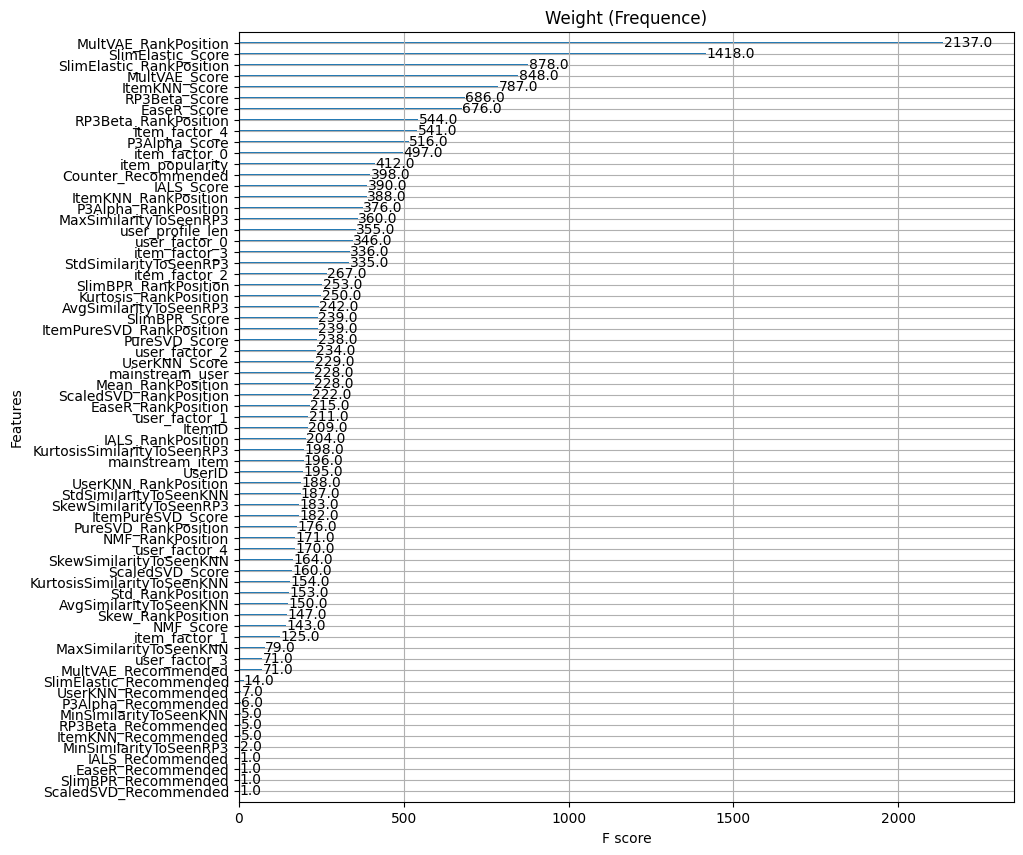

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

In [66]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1924.95 column/sec. Elapsed time 11.61 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1167.81 column/sec. Elapsed time 11.15 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3757.70 column/sec. Elapsed time 5.95 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity col

In [67]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    # 'ALS': recommender_als
}

In [68]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/1139215485.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,100,0.999999,0.0,1.0,0.474078,1.0,1.0,0.786014,1.0,...,0.045669,0.010442,0.052225,-0.058731,0.022079,0.005573,0.000276,0.007794,-0.010626,-0.001530
27,0,111,0.082615,73.0,0.0,0.121925,11.0,0.0,0.000000,7415.0,...,0.040914,-0.012057,0.014528,-0.047855,-0.023098,0.005573,0.000276,0.007794,-0.010626,-0.001530
28,0,215,0.180754,23.0,0.0,0.012160,1619.0,0.0,0.085517,21.0,...,0.035591,0.015862,-0.019037,0.043913,0.006133,0.005573,0.000276,0.007794,-0.010626,-0.001530
29,0,1082,0.257622,16.0,0.0,0.028504,397.0,0.0,0.088188,20.0,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
30,0,1337,0.235539,18.0,0.0,0.008058,3644.0,0.0,0.064524,39.0,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651189,13023,1238,0.097473,58.0,0.0,0.442709,21.0,0.0,0.073992,64.0,...,0.006622,-0.016999,0.013130,0.007500,0.036445,0.009693,-0.007923,-0.000422,0.004503,0.023066
651150,13023,732,0.576149,5.0,1.0,0.711712,0.0,1.0,0.773915,2.0,...,0.016157,-0.035325,0.015268,0.016982,0.054950,0.009693,-0.007923,-0.000422,0.004503,0.023066
651180,13023,685,0.047530,102.0,0.0,0.459579,17.0,0.0,0.000000,7209.0,...,0.010855,-0.026114,0.011748,0.007983,0.029280,0.009693,-0.007923,-0.000422,0.004503,0.023066
651153,13023,2119,0.660220,2.0,1.0,0.547857,5.0,1.0,0.593510,6.0,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [69]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [70]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,36 101 506 403 515 123 1546 694 977 52
1,2,1095 1522 12 47 11 50 2 28 196 5
2,3,59 4252 259 857 648 536 584 9 414 956
3,4,249 28 50 7 1 5 139 146 171 314
4,5,1570 5138 77 131 471 1511 170 95 1220 4
